In [22]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score
from joblib import dump

## Построение материального баланса для двух реакций

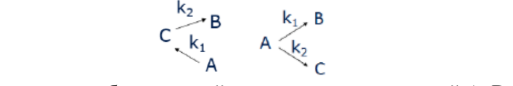

In [2]:
# 1) последовательные реакции
def reaction_1(t, y, k1, k2):
    CA, CB, CC = y

    dCA = -k1 * CA
    dCC = k1 * CA - k2 * CC
    dCB = k2 * CC

    return [dCA, dCB, dCC]

# 2) разветвленные параллельные реакции
def reaction_2(t, y, k1, k2):
    CA, CB, CC = y

    dCA = -(k1 + k2) * CA
    dCB = k1 * CA
    dCC = k2 * CA

    return [dCA, dCB, dCC]

## Генерация и предобработка данных

### Функция, генерирующая концентрации A, B, C для заданных начальных значений

In [3]:
def generate_curve(reaction_func, t_eval, k1=None, k2=None, CA0=None, CB0=None, CC0=None):
    # случайные параметры, если они не переданы
    k1 = k1 if k1 is not None else np.random.uniform(0.01, 0.5)
    k2 = k2 if k2 is not None else np.random.uniform(0.01, 0.5)

    CA0 = CA0 if CA0 is not None else np.random.uniform(0.5, 2.0)
    CB0 = CB0 if CB0 is not None else np.random.uniform(0.0, 0.5)
    CC0 = CC0 if CC0 is not None else 0.0

    y0 = [CA0, CB0, CC0]
    
    # микроколебания времени
    t_raw = t_eval.copy()
    t_raw += np.random.uniform(-0.2, 0.2, len(t_raw))
    t_raw = np.sort(t_raw)

    # решаем ОДУ
    sol = solve_ivp(
        lambda t, y: reaction_func(t, y, k1, k2),
        (t_raw[0], t_raw[-1]),
        y0,
        t_eval=t_raw
    )

    CA, CB, CC = sol.y

    # погрешность +-5%
    error_rate = 0.05
    noise = lambda x: np.clip(x * np.random.uniform(1-error_rate, 1+error_rate, len(x)), 0, None)
    CA, CB, CC = noise(CA), noise(CB), noise(CC)

    # формируем вход (len(t_raw), 4)
    X = np.stack([t_raw, CA, CB, CC], axis=1)

    return X

### Проверка работы функции и построение графиков

Построим графики на основе сгенерированных данных с фиксированными начальнымы значениями

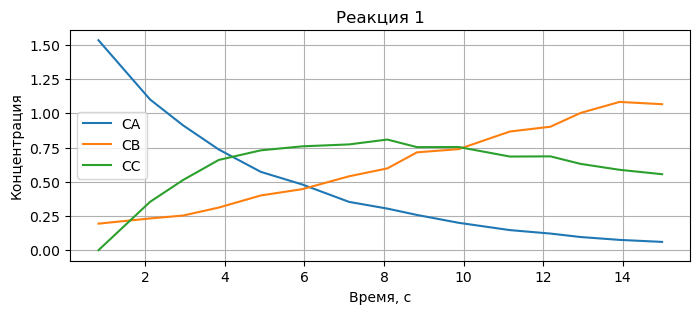

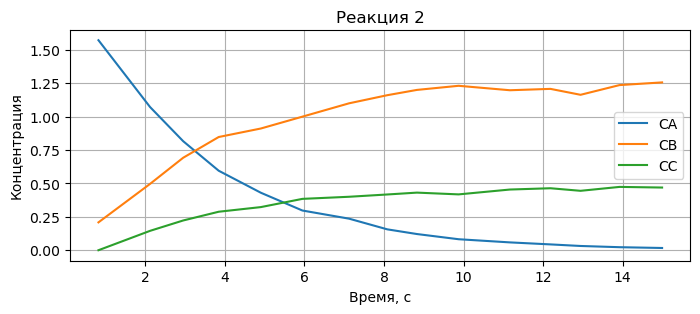

In [4]:
n_points = 15 # количество измерений
dt = 1 # интервал измерений
t_eval = np.arange(1, n_points*dt+1e-9, dt)

k1=0.225
k2=0.1
CA0=1.5
CB0=0.2
CC0=0

x1 = generate_curve(reaction_1, t_eval, k1, k2, CA0, CB0, CC0)
x2 = generate_curve(reaction_2, t_eval, k1, k2, CA0, CB0, CC0)

plt.figure(figsize=(8, 3))
plt.plot(x1[:,0], x1[:,1], label='CA')
plt.plot(x1[:,0], x1[:,2], label='CB')
plt.plot(x1[:,0], x1[:,3], label='CC')
plt.xlabel("Время, с")
plt.ylabel("Концентрация")
plt.title("Реакция 1")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(x1[:,0], x2[:,1], label='CA')
plt.plot(x1[:,0], x2[:,2], label='CB')
plt.plot(x1[:,0], x2[:,3], label='CC')
plt.xlabel("Время, с")
plt.ylabel("Концентрация")
plt.title("Реакция 2")
plt.legend()
plt.grid()
plt.show()

Сохраняем примеры в файл

In [5]:
np.savetxt('../../test1.csv', x1, delimiter=',', fmt='%.4f')
np.savetxt('../../test2.csv', x2, delimiter=',', fmt='%.4f')

### Генерация датасета

In [6]:
def generate_dataset(n_samples=5000):
    np.random.seed(123)
    
    X_list = []
    y_list = []

    for _ in range(n_samples):
        X_list.append(generate_curve(reaction_1, t_eval))
        y_list.append(0)  # реакция 1

    for _ in range(n_samples):
        X_list.append(generate_curve(reaction_2, t_eval))
        y_list.append(1)  # реакция 2

    X = np.array(X_list) 
    y = np.array(y_list)

    # перемешивание
    idx = np.random.permutation(len(X))
    return X[idx], y[idx]

In [7]:
X, y = generate_dataset()
X.shape, y.shape

((10000, 15, 4), (10000,))

### Разделение на train/val/test

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=123)

X_train.shape, X_val.shape

((7000, 15, 4), (1500, 15, 4))

### Создание классов предобработки для Pipeline

Нормализация по концентрациям и по времени

In [10]:
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scalers = [StandardScaler() for _ in range(3)] # для A, B, C
        self.time_scaler = MinMaxScaler() # для времени

    def fit(self, X, y=None):
        for i in range(3):
            self.scalers[i].fit(X[:, :, i+1])
        self.time_scaler.fit(X[:, :, 0].reshape(-1, 1))
        return self

    def transform(self, X):
        X_new = X.copy()
        for i in range(3):
            X_new[:, :, i+1] = self.scalers[i].transform(X[:, :, i+1])
        X_new[:, :, 0] = self.time_scaler.transform(X[:, :, 0].reshape(-1, 1)).reshape(X.shape[0], X.shape[1])
        return X_new

Reshape

In [11]:
class Reshaper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reshape(X.shape[0], -1)

## Обучение моделей

### Однослойный перцептрон

In [26]:
clf = Pipeline([
    ('scale', Scaler()),
    ('reshape', Reshaper()),
    ('model', Perceptron())
])

clf.fit(X_train, y_train)
val_pred = clf.predict(X_val)

print(classification_report(y_val, val_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       750
           1       0.98      0.97      0.98       750

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



### MLP

In [25]:
mlp = Pipeline([
    ('scale', Scaler()),
    ('reshape', Reshaper()),
    ('model', MLPClassifier(
        hidden_layer_sizes=(16,16), 
        activation='relu', 
        solver='adam',
        early_stopping=True,
        random_state=123
    ))
])

mlp.fit(X_train, y_train)
val_pred = mlp.predict(X_val)

print(classification_report(y_val, val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       750
           1       1.00      1.00      1.00       750

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



## Тестирование

In [14]:
print(classification_report(y_test, mlp.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       750
           1       1.00      1.00      1.00       750

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



Сохранение модели в файл

In [15]:
dump(mlp, "../models/mlp_model.joblib")

['../models/mlp_model.joblib']